# Weather Prediction Example
This template shows how to fetch weather data for a particular zip code from the Metis Machine data engine, and then use those data to train a dummy [recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network) that will predict some aspect of the weather from the historical time series at that location.
Obviously, weather modeling is not actually this easy, but the following code shows how to:
* access data via the Metis Machine data engine
* transform those data using a deep learning model
* persist the resulting transformation so that it can be accessed via an outward-facing API

In [57]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from datetime import datetime
import pandas as pd

## Access weather data using the Metis Machine SDK
Any data intake or model project on the platform begins by initializing the Skafos SDK.
This allows your task to access the resources of the platform, as well as ensures proper health monitoring.

*Unresponsive tasks will eventually be purged.*

In [50]:
from skafossdk import *
print('Initializing the SDK connection')
skafos = Skafos()

initializing the SDK connection
2018-01-04 14:24:13,733 - skafossdk.data_engine - INFO - DataEngine Connection Opened
2018-01-04 14:24:14,642 - skafossdk.monitor - INFO - Monitor Connection Opened


In [2]:
res = skafos.engine.create_view(
    "weather_noaa", {"keyspace": "weather",
                      "table": "weather_noaa"}, DataSourceType.Cassandra).result()
print("created a view of NOAA historial weather data")

2018-01-03 17:44:03,802 - skafossdk.data_engine - INFO - Creating View...
2018-01-03 17:44:03,803 - skafossdk.data_engine - INFO - Sending msg...
created a view of NOAA historial weather data


In [3]:
print("pulling historical weather from a single zip code")
weather_json = skafos.engine.query("SELECT * from weather_noaa WHERE zipcode = 23250").result()

pulling historical weather from a single zip code
2018-01-03 17:44:12,064 - skafossdk.data_engine - INFO - Querying ...
2018-01-03 17:44:12,065 - skafossdk.data_engine - INFO - Sending msg...
2018-01-03 17:44:15,929 - skafossdk.monitor - INFO - Monitor Connection Closed


In [4]:
# validate a single record
weather_json['data'][0]

{'date': '2008-10-03T00:00:00Z',
 'precip_total': 0.0,
 'pressure_avg': 29.81999969482422,
 'rh_avg': 66.0,
 'sunrise': '608',
 'sunset': '1747',
 'tmax': 74.0,
 'tmin': 45.0,
 'wind_speed_peak': 26.0,
 'zipcode': '23250'}

In [5]:
# convert retrieved records to a dataframe
import pandas as pd
weather = pd.DataFrame(weather_json['data'])
weather['date']  = pd.to_datetime(weather['date'])

In [6]:
# validate this is what we expect, missing values may throw off pandas types
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 10 columns):
date               3550 non-null datetime64[ns]
precip_total       3550 non-null object
pressure_avg       3550 non-null object
rh_avg             3550 non-null object
sunrise            3550 non-null object
sunset             3550 non-null object
tmax               3550 non-null float64
tmin               3549 non-null float64
wind_speed_peak    3550 non-null object
zipcode            3550 non-null object
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 277.4+ KB


In [7]:
# some numerical values do not show as such, clean missing records
weather['precip_total'] = weather['precip_total'].replace('NaN', None, regex=False).fillna(0)
weather['pressure_avg'] = weather['pressure_avg'].replace('NaN', None, regex=False).fillna(0)
weather['wind_speed_peak'] = weather['wind_speed_peak'].replace('NaN', None, regex=False).fillna(0)

In [9]:
# verify that we now have all the float columns we expected
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 10 columns):
date               3550 non-null datetime64[ns]
precip_total       3550 non-null float64
pressure_avg       3550 non-null float64
rh_avg             3550 non-null object
sunrise            3550 non-null object
sunset             3550 non-null object
tmax               3550 non-null float64
tmin               3549 non-null float64
wind_speed_peak    3550 non-null float64
zipcode            3550 non-null object
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 277.4+ KB


# Prep inputs for modeling
We want to use a recurrent time-series model, so our data need to be in ascending order by date.

In [10]:
day_zero = weather['date'].min()

In [11]:
weather.set_index((weather['date'] - day_zero).apply(lambda d: d.days), inplace=True)
weather.sort_index(inplace=True)

## Feature Engineering
These are not necessarilly excellent features, but simply illustrate a common step in the predictive process.

* length of day
* average temperature
* change in average temperature
* change in barometric pressure
* precipitation
* wind speed peak

In [12]:
weather['precip_total'].fillna(0, inplace=True)

In [13]:
weather['day_length'] = weather.apply(lambda r: int(r.sunset) - int(r.sunrise), axis=1)

In [14]:
weather['tavg'] = (weather.tmax + weather.tmin) / 2

In [15]:
weather['pressure_change'] = weather['pressure_avg'].pct_change()

In [16]:
weather['temp_change'] = weather['tavg'].pct_change()

In [17]:
weather_features = weather[
    ['day_length', 'tavg', 'tmin', 'tmax', 'temp_change', 'pressure_change', 'precip_total', 'wind_speed_peak']].dropna()

In [19]:
# validate inputs to the RNN
weather_features.iloc[:6]

,day_length,tavg,tmin,tmax,temp_change,pressure_change,precip_total,wind_speed_peak
date,,,,,,,,
1,980,32.0,27.0,37.0,-0.288889,0.004367,0.01,37.0
2,980,26.0,18.0,34.0,-0.187500,0.018395,0.00,32.0
3,981,30.5,16.0,45.0,0.173077,0.000328,0.00,22.0
4,981,38.5,26.0,51.0,0.262295,-0.008207,0.00,17.0
5,983,52.5,39.0,66.0,0.363636,-0.003972,0.84,18.0
6,984,58.5,43.0,74.0,0.114286,0.000000,0.00,16.0


## Normalize inputs for deep learning
Most neural networks expect inputs from -1 to 1

In [22]:
# fit two standard deviations between -1 and 1
weather_norm = weather_features.apply(lambda c: 0.5 * (c - c.mean()) / c.std())

In [83]:
weather_x = weather_norm.drop('tavg', axis=1)
# shift so that we're trying to predict tomorrow
weather_y = weather_norm['tavg'].shift(-1)

In [84]:
# predict on the last two months
predict_day = weather_x.index[-60]

# Recurrent Neural Network Model
[PyTorch](http://pytorch.org) is a wonderful framnework for deep learning since it handles backpropgation automatically.

In [27]:
! pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

    100% |████████████████████████████████| 592.3MB 11.3MB/s ta 0:00:011  6% |██                              | 36.0MB 13.7MB/s eta 0:00:41    46% |███████████████                 | 277.2MB 21.6MB/s eta 0:00:15    52% |████████████████▊               | 309.8MB 17.3MB/s eta 0:00:17    60% |███████████████████▌            | 360.4MB 103.3MB/s eta 0:00:03��███████▌  | 545.2MB 63.3MB/s eta 0:00:018.6MB 79.8MB/s eta 0:00:01��████████████ | 572.4MB 101.2MB/s eta 0:00:011.5MB 105.2MB/s eta 0:00:01��████████████▌| 582.4MB 60.8MB/s eta 0:00:01�██████████████████| 591.8MB 59.9MB/s eta 0:00:01
    100% |████████████████████████████████| 256kB 2.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml


In [28]:
! pip install torchvision

    100% |████████████████████████████████| 51kB 3.8MB/s ta 0:00:011
    100% |████████████████████████████████| 5.9MB 118kB/s eta 0:00:01


In [30]:
! pip install ggplot

    100% |████████████████████████████████| 2.2MB 317kB/s eta 0:00:01    58% |██████████████████▉             | 1.3MB 32.0MB/s eta 0:00:01
    100% |████████████████████████████████| 15.0MB 46kB/s  eta 0:00:01


In [85]:
x_train = torch.autograd.Variable(
    torch.from_numpy(weather_x.loc[:predict_day - 1].as_matrix()).float(), requires_grad=False)
x_test = torch.autograd.Variable(
    torch.from_numpy(weather_x.loc[predict_day:].as_matrix()).float(), requires_grad=False)
batch_size = x_train.size()[0]
input_size = len(weather_x.columns)

In [86]:
y_train = torch.autograd.Variable(
    torch.from_numpy(weather_y.loc[:predict_day - 1].as_matrix()).float(), requires_grad=False)
y_test = torch.autograd.Variable(
    torch.from_numpy(weather_y.loc[predict_day:].as_matrix()).float(), requires_grad=False)

In [87]:
class WeatherNet(torch.nn.Module):
    hidden_layers = 2
    hidden_size = 6
    
    def __init__(self):
        super(WeatherNet, self).__init__()
        # use a small hidden layer since we have such narrow inputs
        self.rnn1 = nn.GRU(input_size=input_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.hidden_layers)
        self.dense1 = nn.Linear(self.hidden_size, 1)

    def forward(self, x, hidden):
        x_batch = x.view(len(x), 1, -1)
        x_r, hidden = self.rnn1(x_batch, hidden)
        x_o = self.dense1(x_r)
        return x_o, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.randn(self.hidden_layers, 1, self.hidden_size))

### Train the RNN
Initialize the hidden layer during training, but keep it for later prediction.

In [88]:
torch.manual_seed(0)
model = WeatherNet()
print(model)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.Adadelta(model.parameters())

WeatherNet(
  (rnn1): GRU(7, 6, num_layers=2)
  (dense1): Linear(in_features=6, out_features=1)
)


In [104]:
hidden = model.init_hidden(batch_size)

for i in range(120):
    def closure():
        model.zero_grad()
        hidden = model.init_hidden(batch_size)
        out, hidden = model(x_train, hidden)
        loss = criterion(out, y_train)
        if i % 10 == 0:
            print('{:%H:%M} epoch {} loss: {}'.format(datetime.now(), i, loss.data.numpy()[0]))
        loss.backward()
        return loss
    optimizer.step(closure)

15:57 epoch 0 loss: 0.040170375257730484
15:57 epoch 5 loss: 0.03973850980401039
15:57 epoch 10 loss: 0.03812502324581146
15:57 epoch 15 loss: 0.036933042109012604
15:57 epoch 20 loss: 0.03646813705563545
15:58 epoch 25 loss: 0.03533492237329483
15:58 epoch 30 loss: 0.034507256001234055
15:58 epoch 35 loss: 0.03448263928294182
15:58 epoch 40 loss: 0.033745478838682175
15:58 epoch 45 loss: 0.033302366733551025
15:58 epoch 50 loss: 0.033223558217287064
15:58 epoch 55 loss: 0.03330598026514053
15:58 epoch 60 loss: 0.03197720646858215
15:59 epoch 65 loss: 0.03133971616625786
15:59 epoch 70 loss: 0.031395141035318375


# Predict
Keep the current hidden state of the model and run it forward without updating parameters

In [105]:
y_pred, new_hidden = model(x_test, hidden)

In [106]:
predictions = pd.DataFrame(y_pred.view(len(y_pred), -1).data.numpy(), columns=['tavg_norm'])
predictions['series'] = 'predicted'

In [107]:
actuals = pd.DataFrame(y_test.data.numpy(), columns=['tavg_norm'])
actuals['series'] = 'actual'

In [108]:
# join for plotting purposes
eval_data = pd.concat([predictions, actuals])
eval_data['day'] = eval_data.index

### UnNormalize Predictions for Display
This was how we normalized the inputs to the RNN, we will just undo that transformation for plotting purposes.
``` python
weather_norm = weather_features.apply(lambda c: 0.5 * (c - c.mean()) / c.std())
```

In [109]:
eval_data['tavg'] = 2. * eval_data['tavg_norm'] * weather_features['tavg'].std() + weather_features['tavg'].mean() 

In [110]:
import ggplot as gg

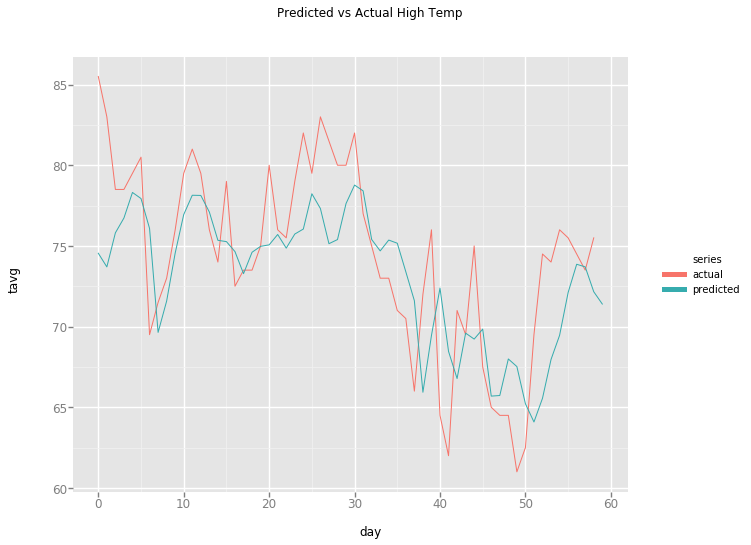

<ggplot: (8771747797042)>

In [111]:
gg.ggplot(gg.aes(x='day', y='tavg', color='series'),
          data=eval_data) + gg.geom_line() + gg.ggtitle("Predicted vs Actual High Temp")

# Persist Predictions

In [112]:
# define the schema for this dataset
schema = {
    "table_name": "rnn_weather_predictions",
    "options": {
        "primary_key": ["day", "actual"],
        "order_by": ["actual asc"]
    },
    "columns": {
        "day": "int",
        "tavg": "float",
        "series": "text"
    }
}

In [113]:
data_out = eval_data.dropna().drop('tavg_norm', axis=1).to_dict(orient='records')

In [114]:
dataresult = skafos.engine.save(schema, data_out).result()

2018-01-04 16:00:23,576 - skafossdk.data_engine - INFO - Saving Data ...
2018-01-04 16:00:23,578 - skafossdk.data_engine - INFO - Sending msg...


## Accessing persisted data
Ingested data is available from the Metis Machine API using your credentials as described in the [API docs](https://docs.metismachine.io/docs/api-accessing-your-results)